`March 31, 2022`

### **Model Evaluation Exercise**

#### **Use Titanic dataset'**

**Target: 'alive'**

- Explore the data.

- Preprocessing schemas:
  * Drop unnecessary feature.
  * Impute missing values if any.
  * Encode features if needed.
<br><br>
- Split data with ratio 80:20 and random_state = 0.
- Define the evaluation metric that most suitable for this case.

- According to the cross-validation result, find the best model from the list of models you use (n_splits=5).

- You can use any hyperparameter in each model.
  
- Interpret the metric chosen!

<hr>

### **Import Libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, average_precision_score

import warnings
warnings.filterwarnings('ignore')

### **Explore Dataset**

In [2]:
df= pd.read_csv('titanic.csv')
df.head()

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          891 non-null    object 
 1   age          714 non-null    float64
 2   parch        891 non-null    int64  
 3   fare         891 non-null    float64
 4   class        891 non-null    object 
 5   deck         203 non-null    object 
 6   embark_town  889 non-null    object 
 7   alive        891 non-null    object 
 8   alone        891 non-null    bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 56.7+ KB


In [4]:
df['parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64

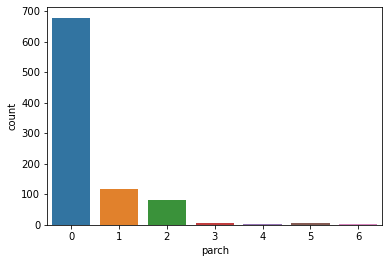

In [5]:
sns.countplot(x=df['parch']);

In [6]:
df['alive'].value_counts()

no     549
yes    342
Name: alive, dtype: int64

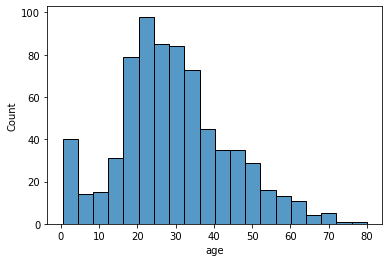

In [7]:
sns.histplot(df['age']);

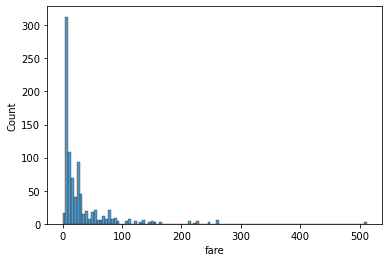

In [8]:
sns.histplot(df['fare']);

In [9]:
df[df.duplicated(keep=False)]

,sex,age,parch,fare,class,deck,embark_town,alive,alone
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True
26,male,NaN,0,7.2250,Third,NaN,Cherbourg,no,True
28,female,NaN,0,7.8792,Third,NaN,Queenstown,yes,True
29,male,NaN,0,7.8958,Third,NaN,Southampton,no,True
32,female,NaN,0,7.7500,Third,NaN,Queenstown,yes,True
...,...,...,...,...,...,...,...,...,...
870,male,26.0,0,7.8958,Third,NaN,Southampton,no,True
877,male,19.0,0,7.8958,Third,NaN,Southampton,no,True
878,male,NaN,0,7.8958,Third,NaN,Southampton,no,True
884,male,25.0,0,7.0500,Third,NaN,Southampton,no,True


In [10]:
df.isna().sum()

sex              0
age            177
parch            0
fare             0
class            0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [11]:
# Drop feature 'deck'
df = df.drop(columns='deck')

### **Define X and y**

In [74]:
X = df.drop(columns=['parch', 'alive'])
y = np.where(df['alive'] == 'yes', 1, 0)

### **Data Splitting**

In [75]:
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y, 
    stratify = y,  
    test_size = 0.2,
    random_state = 0)

### **Data Transformation**

In [76]:
onehot = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one hot', OneHotEncoder(drop='first'))
])

mapping = [{'col':'class', 'mapping':{None: 0, 'First':3, 'Second':2, 'Third':1}}]
ordinal = ce.OrdinalEncoder(mapping=mapping)

transformer = ColumnTransformer([
    ('One Hot1', onehot, ['embark_town']),
    ('One Hot2', OneHotEncoder(drop='first'), ['sex', 'alone']),
    ('Ordinal', ordinal, ['class']),
    ('Impute', KNNImputer(n_neighbors=7), ['age'])
], remainder='passthrough')

In [77]:
X_train_preprocessed = pd.DataFrame(transformer.fit_transform(X_train))
X_test_preprocessed = pd.DataFrame(transformer.transform(X_test))

In [100]:
print(transformer.transformers_[0][1][1].get_feature_names())
print(transformer.transformers_[1][1].get_feature_names())
print(transformer.transformers_[2][1].get_feature_names())

['x0_Queenstown' 'x0_Southampton']
['x0_male' 'x1_True']
['class']


In [84]:
X_train_preprocessed

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,1.0,1.0,29.469823,7.6292
1,0.0,1.0,1.0,1.0,1.0,29.469823,8.0500
2,1.0,0.0,0.0,1.0,1.0,29.469823,7.7500
3,0.0,1.0,0.0,0.0,3.0,51.000000,77.9583
4,1.0,0.0,1.0,1.0,1.0,21.000000,7.7333
...,...,...,...,...,...,...,...
707,0.0,1.0,1.0,1.0,1.0,20.000000,7.0500
708,0.0,1.0,1.0,0.0,1.0,29.469823,19.9667
709,0.0,1.0,1.0,1.0,1.0,39.000000,7.9250
710,0.0,0.0,1.0,0.0,1.0,29.469823,21.6792


In [99]:
features = list(transformer.transformers_[0][1][1].get_feature_names()) + list(transformer.transformers_[1][1].get_feature_names()) + transformer.transformers_[2][1].get_feature_names() + ['age', 'fare']

X_train_preprocessed.columns = features
X_test_preprocessed.columns = features
X_train_preprocessed

,x0_Queenstown,x0_Southampton,x0_male,x1_True,class,age,fare
0,1.0,0.0,0.0,1.0,1.0,29.469823,7.6292
1,0.0,1.0,1.0,1.0,1.0,29.469823,8.0500
2,1.0,0.0,0.0,1.0,1.0,29.469823,7.7500
3,0.0,1.0,0.0,0.0,3.0,51.000000,77.9583
4,1.0,0.0,1.0,1.0,1.0,21.000000,7.7333
...,...,...,...,...,...,...,...
707,0.0,1.0,1.0,1.0,1.0,20.000000,7.0500
708,0.0,1.0,1.0,0.0,1.0,29.469823,19.9667
709,0.0,1.0,1.0,1.0,1.0,39.000000,7.9250
710,0.0,0.0,1.0,0.0,1.0,29.469823,21.6792


## **Modeling**

In [ ]:
# Define the models
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(max_depth=3)

In [ ]:
models = [logreg, knn, tree]
nilai_mean = []
nilai_std = []

for i in models:
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(i, X_train_preprocessed, y_train, cv = skfold, scoring = 'f1')
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [ ]:
pd.DataFrame({
    'model': ['logreg','knn','tree'],
    'mean': nilai_mean,
    'std': nilai_std
})

,model,mean,std
0,logreg,0.721572,0.056616
1,knn,0.574685,0.028436
2,tree,0.725342,0.048717


### **Interpretasi**

Di antara ketiga model, nilai rata-rata precision yang paling tinggi adalah model Decision tree, mencapai 72.5%. Di sisi lain, model KNN menjadi model yang paling stabil karena nilai rata-rata standar deviasinya terkecil, meskipun tidak terpaut jauh juga dengan Decision tree. Oleh karena itu, model Decision tree dipilih sebagai model terbaik untuk kasus Titanic ini.

In [ ]:
# Model performance in test set
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
y_pred = tree.predict(X_test_preprocessed)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [ ]:
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Precision: 0.7966101694915254
Recall: 0.6811594202898551
F1 score: 0.7343750000000001


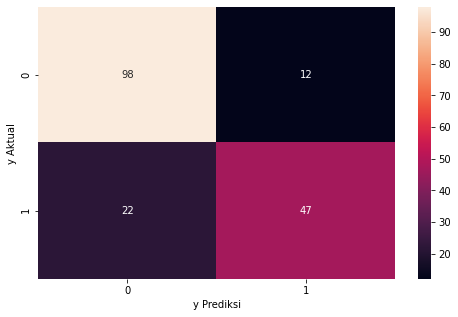

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

### **Interpretasi**

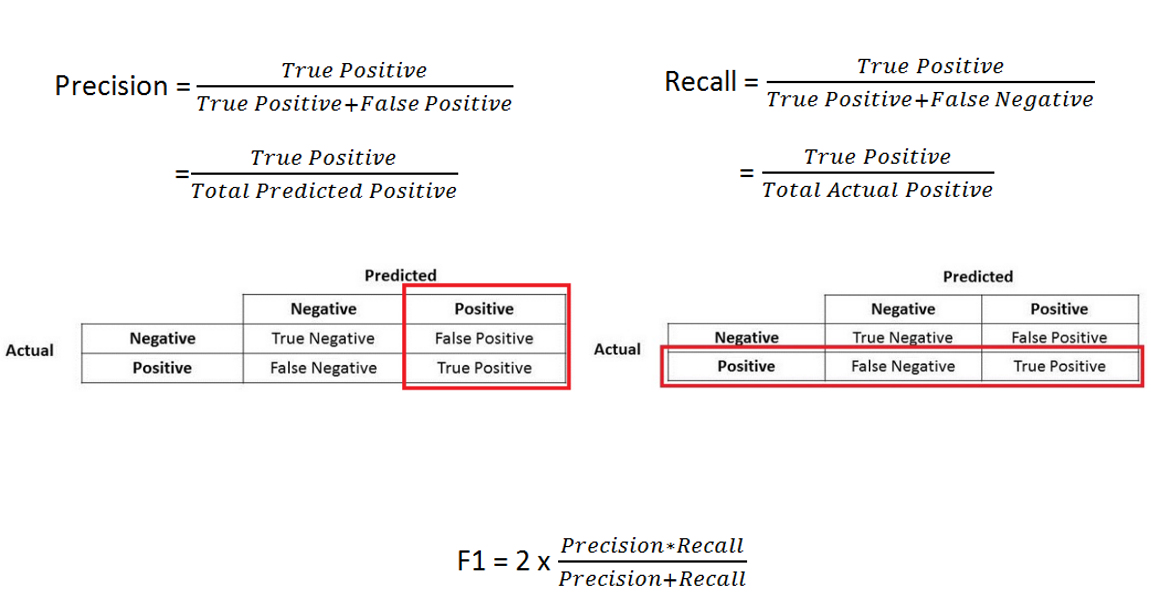

### **Precision**
Precision menggambarkan seberapa akurat model dalam membedakan mana yang aktualnya memang positif dari semua data yang terprediksi positif.

Precision cocok digunakan jika cost untuk False Positive dinilai tinggi. Jika kita menggunakan metric precision, itu berarti kita berusaha untuk meminimalkan jumlah false positive yang dihasilkan oleh model. Namun, perlu selalu diingat bahwa selalu ada trade off antara precision dan recall.

Jadi, dalam kasus Titanic ini, false positive berarti penumpang yang diprediksi survived oleh model, namun aktualnya tidak survived. Dari rumus precision di atas dan dihubungkan dengan kasus Titanic, nilai precision berarti menggambarkan 'dari semua penumpang yang diklasifikasikan sebagai penumpang yang selamat, berapa banyak yang sebenarnya selamat?'

Nilai precision 80% berarti 80% dari total penumpang yang diklasifikasikan selamat (59 penumpang), yang sebenarnya selamat berjumlah 47 penumpang.

### **Recall**
Recall menggambarkan berapa banyak jumlah aktual positif yang dapat diprediksi oleh model.

Recall cocok digunakan jika cost untuk False Negative dinilai tinggi. Jika kita menggunakan metric recall, itu berarti kita berusaha untuk meminimalkan jumlah false negative yang dihasilkan oleh model. 

Dalam kasus Titanic, false negative berarti penumpang yang diprediksi tidak selamat, namun aktualnya selamat. Itu berarti, nilai recall merepresentasikan 'dari semua penumpang yang selamat, berapa orang yang diklasifikasikan selamat?'

Nilai recall 68% berarti dari total 69 penumpang yang selamat, hanya 47 penumpang yang diklasifikasikan selamat oleh model.

### **F1-score**

Pada binary classification, metrik F1-score menggambarkan rata-rata harmonik dari nilai precision dan recall. Nilai F1-score tergantung pada nilai precision dan recall yang didapat. Semakin tinggi nilai precision dan recall, semakin tinggi pula nilai F1-score, dan berlaku sebaliknya.

### **ROC AUC Curve**

ROC = kurva probabilitas

Pada binary classification, ROC AUC curve cocok digunakan ketika kita tertarik pada kedua kelas.

ROC AUC score merepresentasikan score yang didapat dari ROC AUC curve atau dengan kata lain hasil kalkulasi area under the curve. ROC AUC score menggambarkan seberapa baik model dapat membedakan antar kelas.

Model classifiers yang memiliki persentase 100% benar dalam prediksinya, akan memiliki ROC AUC score = 1, sedangkan yang terburuk adalah dengan score 0.5 (sama saja dengan random classifier).

In [ ]:
y_proba = tree.predict_proba(X_test_preprocessed)
y_proba = y_proba[:, 1]

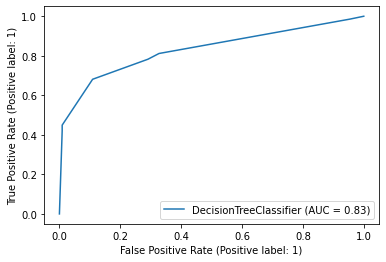

In [ ]:
plot_roc_curve(tree, X_test_preprocessed, y_test);

Nilai AUC 83% berarti ada kemungkinan 83% model dapat membedakan antar kelas positif dan negatif.

In [ ]:
roc_auc_score(y_test, y_proba)

0.8292490118577076

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)

In [ ]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'fpr':fpr,
    'tpr':tpr,
    'thresholds':thresholds    
})

,fpr,tpr,thresholds
0,0.000000,0.000000,1.949275
1,0.009091,0.420290,0.949275
2,0.009091,0.449275,0.846154
3,0.109091,0.681159,0.574468
4,0.290909,0.782609,0.389381
5,0.327273,0.811594,0.111111
6,0.954545,0.985507,0.091483
7,1.000000,1.000000,0.058824


### **Precision-Recall Curve**

Precision-Recall curve dapat membantu memvisualisasikan bagaimana tiap threshold memengaruhi performa dari model classifier.

Nilai AP yang dihasilkan pada Precision-Recall curve merepresentasikan nilai rata-rata precision dari semua threshold.

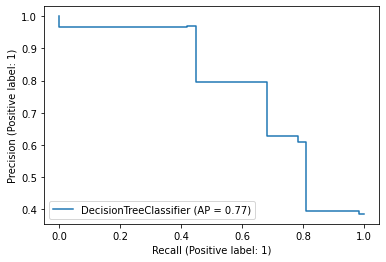

In [ ]:
plot_precision_recall_curve(tree, X_test_preprocessed, y_test);

In [ ]:
average_precision_score(y_test, y_proba)

0.7743706384473972

In [ ]:
p, r, th = precision_recall_curve(y_test, y_proba)

In [ ]:
th = list(th)
th.insert(0, 0)

In [ ]:
th

[0,
 0.058823529411764705,
 0.0914826498422713,
 0.1111111111111111,
 0.3893805309734513,
 0.574468085106383,
 0.8461538461538461,
 0.9492753623188406]

In [ ]:
pd.DataFrame({
    'recall':r,
    'precision':p,
    'threshold':th
})

,recall,precision,threshold
0,1.000000,0.385475,0.000000
1,0.985507,0.393064,0.058824
2,0.811594,0.608696,0.091483
3,0.782609,0.627907,0.111111
4,0.681159,0.796610,0.389381
5,0.449275,0.968750,0.574468
6,0.420290,0.966667,0.846154
7,0.000000,1.000000,0.949275


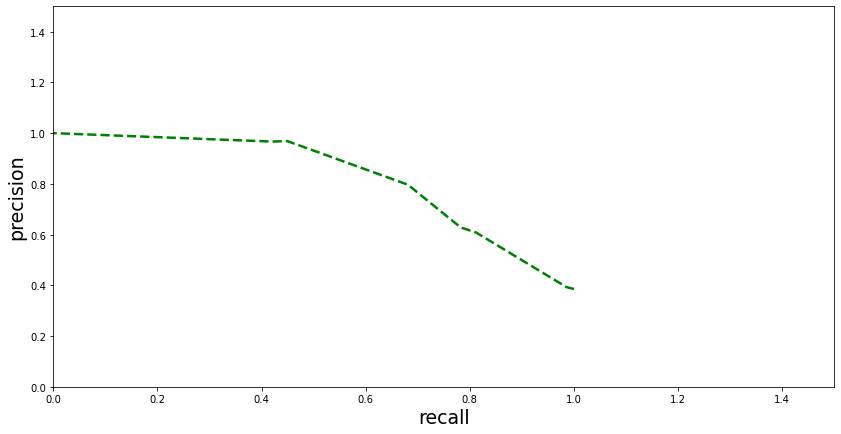

In [ ]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, 'g--', linewidth=2.5)
    plt.xlabel('recall', fontsize=19)
    plt.ylabel('precision', fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(p, r)
plt.show()

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df= pd.read_csv('titanic.csv')
df.head()

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          891 non-null    object 
 1   age          714 non-null    float64
 2   parch        891 non-null    int64  
 3   fare         891 non-null    float64
 4   class        891 non-null    object 
 5   deck         203 non-null    object 
 6   embark_town  889 non-null    object 
 7   alive        891 non-null    object 
 8   alone        891 non-null    bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 56.7+ KB


In [ ]:
# Drop feature 'deck'
df = df.drop(columns='deck')

## **Define X and y**

In [ ]:
X = df.drop(columns='alive')
y = np.where(df['alive'] == 'yes', 1, 0)

In [ ]:
X

,sex,age,parch,fare,class,embark_town,alone
0,male,22.0,0,7.2500,Third,Southampton,False
1,female,38.0,0,71.2833,First,Cherbourg,False
2,female,26.0,0,7.9250,Third,Southampton,True
3,female,35.0,0,53.1000,First,Southampton,False
4,male,35.0,0,8.0500,Third,Southampton,True
...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,Southampton,True
887,female,19.0,0,30.0000,First,Southampton,True
888,female,NaN,2,23.4500,Third,Southampton,False
889,male,26.0,0,30.0000,First,Cherbourg,True


## **Data Splitting**

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y, 
    stratify = y,  
    test_size = 0.2,
    random_state = 0)

## **Data Transformation**

In [ ]:
onehot = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one hot', OneHotEncoder(drop='first'))
])

mapping = [{'col':'class', 'mapping':{None: 0, 'First':1, 'Second':2, 'Third':3}}]
ordinal = ce.OrdinalEncoder(mapping=mapping)

transformer= ColumnTransformer([
    ('One Hot1', onehot, ['embark_town']),
    ('One Hot2', OneHotEncoder(drop='first'), ['sex', 'alone']),
    ('Ordinal', ordinal, ['class']),
    ('Impute', SimpleImputer(strategy='median'), ['age'])
], remainder='passthrough')

In [ ]:
X_train_preprocessed = pd.DataFrame(transformer.fit_transform(X_train))
X_test_preprocessed = pd.DataFrame(transformer.transform(X_test))

## **Modeling**

In [ ]:
# Define the models
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(max_depth=3)

In [ ]:
models = [logreg, knn, tree]
nilai_mean = []
nilai_std = []

for i in models:
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(i, X_train_preprocessed, y_train, cv = skfold, scoring = 'f1')
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [ ]:
pd.DataFrame({
    'model': ['logreg','knn','tree'],
    'mean': nilai_mean,
    'std': nilai_std
})

,model,mean,std
0,logreg,0.721572,0.056616
1,knn,0.574685,0.028436
2,tree,0.725342,0.048717


### **Interpretasi**

Di antara ketiga model, nilai rata-rata precision yang paling tinggi adalah model Decision tree, mencapai 72.5%. Di sisi lain, model KNN menjadi model yang paling stabil karena nilai rata-rata standar deviasinya terkecil, meskipun tidak terpaut jauh juga dengan Decision tree. Oleh karena itu, model Decision tree dipilih sebagai model terbaik untuk kasus Titanic ini.

In [ ]:
# Model performance in test set
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
y_pred = tree.predict(X_test_preprocessed)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [ ]:
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Precision: 0.7966101694915254
Recall: 0.6811594202898551
F1 score: 0.7343750000000001


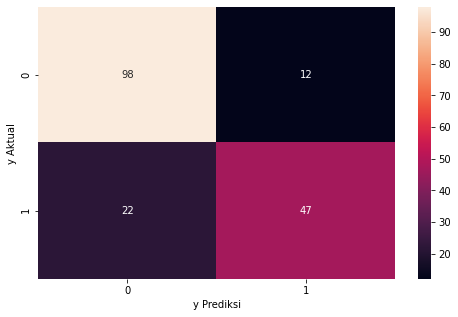

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

### **Interpretasi**

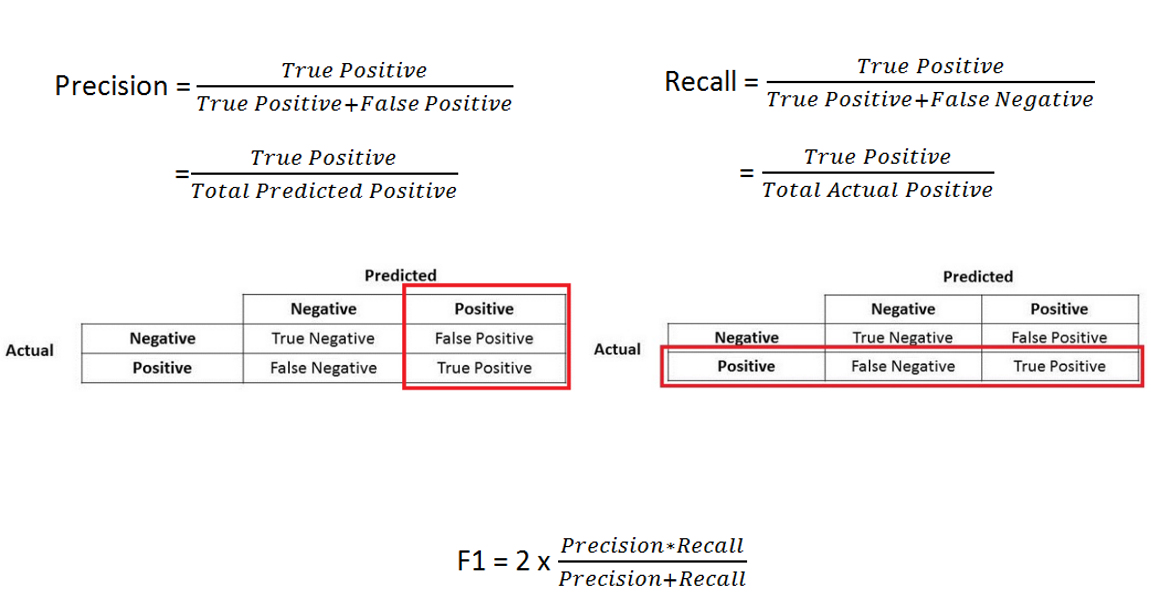

### **Precision**
Precision menggambarkan seberapa akurat model dalam membedakan mana yang aktualnya memang positif dari semua data yang terprediksi positif.

Precision cocok digunakan jika cost untuk False Positive dinilai tinggi. Jika kita menggunakan metric precision, itu berarti kita berusaha untuk meminimalkan jumlah false positive yang dihasilkan oleh model. Namun, perlu selalu diingat bahwa selalu ada trade off antara precision dan recall.

Jadi, dalam kasus Titanic ini, false positive berarti penumpang yang diprediksi survived oleh model, namun aktualnya tidak survived. Dari rumus precision di atas dan dihubungkan dengan kasus Titanic, nilai precision berarti menggambarkan 'dari semua penumpang yang diklasifikasikan sebagai penumpang yang selamat, berapa banyak yang sebenarnya selamat?'

Nilai precision 80% berarti 80% dari total penumpang yang diklasifikasikan selamat (59 penumpang), yang sebenarnya selamat berjumlah 47 penumpang.

### **Recall**
Recall menggambarkan berapa banyak jumlah aktual positif yang dapat diprediksi oleh model.

Recall cocok digunakan jika cost untuk False Negative dinilai tinggi. Jika kita menggunakan metric recall, itu berarti kita berusaha untuk meminimalkan jumlah false negative yang dihasilkan oleh model. 

Dalam kasus Titanic, false negative berarti penumpang yang diprediksi tidak selamat, namun aktualnya selamat. Itu berarti, nilai recall merepresentasikan 'dari semua penumpang yang selamat, berapa orang yang diklasifikasikan selamat?'

Nilai recall 68% berarti dari total 69 penumpang yang selamat, hanya 47 penumpang yang diklasifikasikan selamat oleh model.

### **F1-score**

Pada binary classification, metrik F1-score menggambarkan rata-rata harmonik dari nilai precision dan recall. Nilai F1-score tergantung pada nilai precision dan recall yang didapat. Semakin tinggi nilai precision dan recall, semakin tinggi pula nilai F1-score, dan berlaku sebaliknya.

### **ROC AUC Curve**

ROC = kurva probabilitas

Pada binary classification, ROC AUC curve cocok digunakan ketika kita tertarik pada kedua kelas.

ROC AUC score merepresentasikan score yang didapat dari ROC AUC curve atau dengan kata lain hasil kalkulasi area under the curve. ROC AUC score menggambarkan seberapa baik model dapat membedakan antar kelas.

Model classifiers yang memiliki persentase 100% benar dalam prediksinya, akan memiliki ROC AUC score = 1, sedangkan yang terburuk adalah dengan score 0.5 (sama saja dengan random classifier).

In [ ]:
y_proba = tree.predict_proba(X_test_preprocessed)
y_proba = y_proba[:, 1]

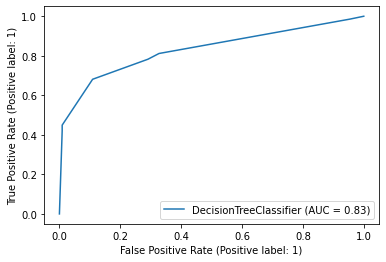

In [ ]:
plot_roc_curve(tree, X_test_preprocessed, y_test);

Nilai AUC 83% berarti ada kemungkinan 83% model dapat membedakan antar kelas positif dan negatif.

In [ ]:
roc_auc_score(y_test, y_proba)

0.8292490118577076

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)

In [ ]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'fpr':fpr,
    'tpr':tpr,
    'thresholds':thresholds    
})

,fpr,tpr,thresholds
0,0.000000,0.000000,1.949275
1,0.009091,0.420290,0.949275
2,0.009091,0.449275,0.846154
3,0.109091,0.681159,0.574468
4,0.290909,0.782609,0.389381
5,0.327273,0.811594,0.111111
6,0.954545,0.985507,0.091483
7,1.000000,1.000000,0.058824


### **Precision-Recall Curve**

Precision-Recall curve dapat membantu memvisualisasikan bagaimana tiap threshold memengaruhi performa dari model classifier.

Nilai AP yang dihasilkan pada Precision-Recall curve merepresentasikan nilai rata-rata precision dari semua threshold.

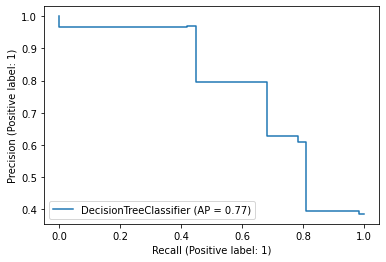

In [ ]:
plot_precision_recall_curve(tree, X_test_preprocessed, y_test);

In [ ]:
average_precision_score(y_test, y_proba)

0.7743706384473972

In [ ]:
p, r, th = precision_recall_curve(y_test, y_proba)

In [ ]:
th = list(th)
th.insert(0, 0)

In [ ]:
th

[0,
 0.058823529411764705,
 0.0914826498422713,
 0.1111111111111111,
 0.3893805309734513,
 0.574468085106383,
 0.8461538461538461,
 0.9492753623188406]

In [ ]:
pd.DataFrame({
    'recall':r,
    'precision':p,
    'threshold':th
})

,recall,precision,threshold
0,1.000000,0.385475,0.000000
1,0.985507,0.393064,0.058824
2,0.811594,0.608696,0.091483
3,0.782609,0.627907,0.111111
4,0.681159,0.796610,0.389381
5,0.449275,0.968750,0.574468
6,0.420290,0.966667,0.846154
7,0.000000,1.000000,0.949275


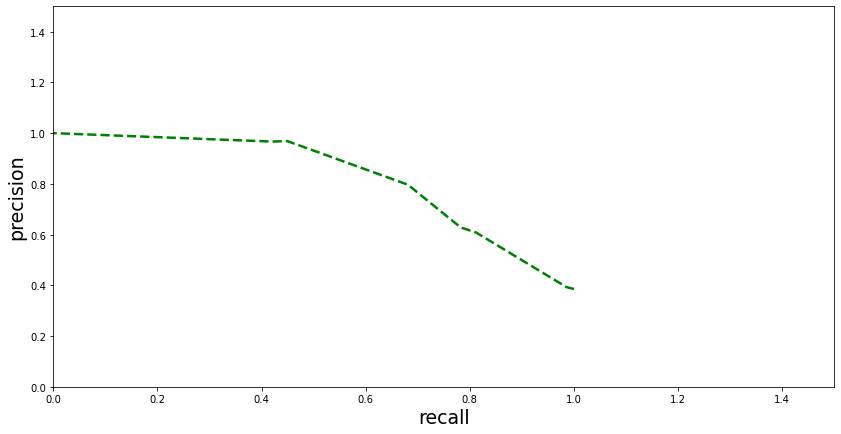

In [ ]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, 'g--', linewidth=2.5)
    plt.xlabel('recall', fontsize=19)
    plt.ylabel('precision', fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(p, r)
plt.show()